### 주의 : 본 코드는 책에 대한 학습 및 교육외에 배포를 금지합니다. 
### Warning: This code is prohibited from distribution except for learning and educational purposes related to the book.
6장 python과 양자화학 소프트웨어의 활용
- by Keunhong Jeong 

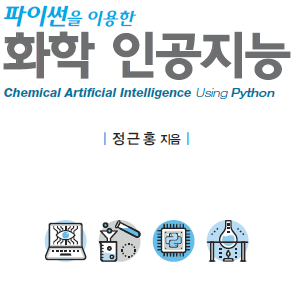

In [ ]:
import os
import subprocess

# Gaussian 입력 파일 생성
input_file = "input.com"
with open(input_file, "w") as f:
    f.write("My Gaussian calculation")  # Gaussian 입력 설정

# Gaussian 실행
subprocess.run(["g16", input_file], capture_output=True)

# 출력 파일 읽기
output_file = "input.log"
with open(output_file, "r") as f:
    output_data = f.read()

# 결과 처리 및 분석
# 예: 에너지 값 추출
energy_line = None
for line in output_data.split("\n"):
    if "SCF Done" in line:
        energy_line = line
        break

if energy_line:
    energy = float(energy_line.split()[4])
    print("계산된 에너지:", energy)
else:
    print("에너지 정보를 찾을 수 없습니다.")

In [ ]:
import openbabel as ob

# SMILES를 분자로 변환
smiles = "CCO"
obConversion = ob.OBConversion()
obConversion.SetInAndOutFormats("smi", "gjf")
mol = ob.OBMol()
obConversion.ReadString(mol, smiles)

# 분자 정보 추출
formula = mol.GetFormula()
charge = mol.GetTotalCharge()

# gjf 파일 생성
gjf_file = "ethanol.gjf"
with open(gjf_file, "w") as f:
    f.write("%chk=ethanol.chk\n")
    f.write(f"%mem=2GB\n")
    f.write(f"%nproc=4\n")
    f.write(f"# MP2/6-31G(d) opt\n\n")
    f.write(f"ethanol\n\n")
    f.write(f"{charge} 1\n")

    # 원자 정보 작성
    for atom in ob.OBMolAtomIter(mol):
        atomic_number = atom.GetAtomicNum()
        x, y, z = atom.GetVector()
        f.write(f"{atomic_number} {x:.6f} {y:.6f} {z:.6f}\n")

    f.write("\n")

# gjf 파일 생성 완료
print(f"ethanol.gjf 파일이 생성되었습니다.")


In [ ]:
!pip install rdkit==2023.03.01

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

# SMILES 문자열로부터 분자 생성
ethanol = Chem.MolFromSmiles('CCO')

# 3차원 좌표 생성
ethanol = Chem.AddHs(ethanol)
AllChem.EmbedMolecule(ethanol)
AllChem.MMFFOptimizeMolecule(ethanol)

# Gaussian 입력 파일 생성
with open('ethanol.gjf', 'w') as f:
    f.write('%nproc=4\n') # 사용할 CPU 코어 수
    f.write('%mem=4GB\n')  # 사용할 메모리 크기
    f.write('# B3LYP/6-31G(d) Opt Freq\n\n') # 계산 메서드와 기저집합
    f.write('Ethanol geometry optimization\n\n') # 작업 설명
    f.write('0 1\n') # 전하 및 스핀 다중도

    # 각 원자의 좌표를 입력 파일에 쓰기
    conf = ethanol.GetConformer()
    for atom in ethanol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        f.write(f'{atom.GetSymbol()}    {pos.x}    {pos.y}    {pos.z}\n')

    f.write('\n\n')


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

# SMILES 코드를 입력받음
smiles = input("Enter the SMILES code of the molecule: ")
filename = input("Enter the desired filename for the Gaussian input file: ")

# SMILES 코드로부터 분자를 생성
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)

# Gaussian 입력 파일을 작성
with open(filename, 'w') as f:
    f.write('%nproc=4\n')
    f.write('%mem=4GB\n')
    f.write('# B3LYP/6-31G(d) Opt Freq\n\n')
    f.write(f'{smiles} geometry optimization\n\n')
    f.write('0 1\n')

    conf = mol.GetConformer()
    for atom in mol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        f.write(f'{atom.GetSymbol()}    {pos.x}    {pos.y}    {pos.z}\n')

    f.write('\n\n')


In [ ]:
!pip install pubchempy==1.0.4

In [ ]:
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import AllChem

# 분자 이름을 입력받음
name = input("Enter the name of the molecule: ")
filename = input("Enter the desired filename for the Gaussian input file: ")

# PubChem에서 분자 이름을 사용하여 Compound를 검색
compounds = pcp.get_compounds(name, 'name')

# 검색된 첫 번째 화합물의 SMILES 코드를 가져옴
smiles = compounds[0].isomeric_smiles

# SMILES 코드로부터 분자를 생성
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)

# Gaussian 입력 파일을 작성
with open(filename, 'w') as f:
    f.write('%nproc=4\n')
    f.write('%mem=4GB\n')
    f.write('# B3LYP/6-31G(d) Opt Freq\n\n')
    f.write(f'{name} geometry optimization\n\n')
    f.write('0 1\n')

    conf = mol.GetConformer()
    for atom in mol.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        f.write(f'{atom.GetSymbol()}    {pos.x}    {pos.y}    {pos.z}\n')

    f.write('\n\n')


In [ ]:
def extract_HOMO_LUMO(gaussian_output_file):
    homo_energy = None
    lumo_energy = None
    with open(gaussian_output_file, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if "Alpha  occ. eigenvalues" in line:
                homo_energy = float(line.split()[-1])
            if "Alpha virt. eigenvalues" in line:
                lumo_energy = float(line.split()[4])
                break
    return homo_energy, lumo_energy

# Test the function
homo, lumo = extract_HOMO_LUMO('ethanol.out')
print(f"HOMO Energy: {homo} Hartree")
print(f"LUMO Energy: {lumo} Hartree")


In [ ]:
def extract_final_energy(gaussian_output_file):
    final_energy = None
    with open(gaussian_output_file, 'r') as file:
        for line in file:
            if "SCF Done" in line:
                final_energy = float(line.split()[4])
    return final_energy

# Test the function
energy = extract_final_energy('ethanol.out')
print(f"Final Energy: {energy} Hartree")


In [ ]:
def extract_dipole_moment(gaussian_output_file):
    dipole_moment = None
    with open(gaussian_output_file, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if "Electric dipole moment (input orientation):" in line:
                dipole_moment = float(lines[i+3].split()[2].replace('D','E'))
    return dipole_moment

# Test the function
dipole = extract_dipole_moment('ethanol.out')
print(f"Dipole Moment: {dipole} Debye")


In [ ]:
def extract_dipole_polarizability(gaussian_output_file):
    dipole_polarizability = None
    with open(gaussian_output_file, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if "Dipole polarizability" in line:
                dipole_polarizability = float(lines[i+4].split()[1].replace('D','E'))
    return dipole_polarizability

# Test the function
polarizability = extract_dipole_polarizability('ethanol.out')
print(f"Dipole Polarizability: {polarizability}")


In [ ]:
def extract_energies(gaussian_output_file):
    energies = {
        'Sum of electronic and zero-point Energies': None,
        'Sum of electronic and thermal Energies': None,
        'Sum of electronic and thermal Enthalpies': None,
        'Sum of electronic and thermal Free Energies': None
    }
    with open(gaussian_output_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            for energy_type in energies.keys():
                if energy_type in line:
                    energies[energy_type] = float(line.split()[-1])
    return energies

# Test the function
energies = extract_energies('ethanol.out')
for energy_type, energy_value in energies.items():
    print(f"{energy_type}: {energy_value}")

In [ ]:
import pandas as pd
import pubchempy as pcp

# CSV 파일 읽기
df = pd.read_csv('book1.csv')

'''for index, row in df.iterrows():
    # PubChem에서 분자 이름을 사용하여 Compound를 검색
    compounds = pcp.get_compounds(row['SMILES'], 'smiles')

    # 검색된 첫 번째 화합물의 SMILES 코드를 가져옴
    smiles = compounds[0].isomeric_smiles

    # SMILES 코드로부터 분자를 생성
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)'''

for index, row in df.iterrows():
    # 화합물의 SMILES 코드를 가져옴
    smiles = row['SMILES']
    
    # SMILES 코드로부터 분자를 생성
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)

    # Gaussian 입력 파일을 작성
    with open(f'{row["NUM"]}.gjf', 'w') as f:
        f.write('%nproc=4\n')
        f.write('%mem=4GB\n')
        f.write('# B3LYP/6-31G(d) Opt Freq\n\n')
        f.write(f'{row["SMILES"]} geometry optimization\n\n')
        f.write('0 1\n')

        conf = mol.GetConformer()
        for atom in mol.GetAtoms():
            pos = conf.GetAtomPosition(atom.GetIdx())
            f.write(f'{atom.GetSymbol()}    {pos.x}    {pos.y}    {pos.z}\n')

        f.write('\n\n')


In [ ]:
import os

folder_path = r"/content" # bcf 만들기위한 gjf있는 파일 지정
folder_path2 = r"C:\Users\Keunhong Jeong\Desktop\PCC"  # 계산 수행하는 (gjf있는)폴더 경로 지정
output_file = "output.bcf"  # 저장할 BCF 파일명

bcf_code = '''!
!batch file
!start=1
!\n'''

gjf_files = [file for file in os.listdir(folder_path) if file.endswith(".gjf")]

for gjf_file in gjf_files:
    gjf_path = os.path.join(folder_path2, gjf_file)
    out_path = os.path.join(folder_path2, gjf_file.replace(".gjf", ".out"))
    bcf_code += f"{gjf_path} , {out_path}\n"

with open(output_file, 'w') as file:
    file.write(bcf_code)


In [ ]:
import glob
import pandas as pd

def extract_final_energy(gaussian_output_file):
    final_energy = None
    with open(gaussian_output_file, 'r') as file:
        for line in file:
            if "SCF Done" in line:
                final_energy = float(line.split()[4])
    return final_energy

# 폴더 내의 모든 .out 파일 경로를 가져오기
#out_files = glob.glob("폴더경로/*.out")  # 폴더경로에는 실제 폴더 경로를 입력해야 합니다.
out_files = glob.glob("*.out")  # 여기선 현재 폴더

# 최종 에너지 추출 및 CSV에 저장
data = []
for out_file in out_files:
    final_energy = extract_final_energy(out_file)
    filename = out_file.split("\\")[-1]  # 파일명 추출
    filename = filename.replace(".out", "")  # .out 확장자 제거
    data.append([filename, final_energy])

df = pd.DataFrame(data, columns=["Filename", "Final Energy (Hartree)"])
df.to_csv("output.csv", index=False)